## Code to process the 3K PBMC example dataset analyzed in the main example

Pipeline from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html with slight adaptation

In [1]:
## Download the raw data
!mkdir -p ../../data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O ../../data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd ../../data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2021-04-20 16:06:30--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-04-20 16:06:30--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘../../data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

../../data/pbmc3k_f 100%[===================>]   7.27M  12.3MB/s    in 0.6s    

2021-04-20 16:06:31 (12.3 MB/s) - ‘../../data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ sa

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
adata = sc.read_10x_mtx(
    '../../data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False)                              # write a cache file for faster subsequent reading

In [4]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

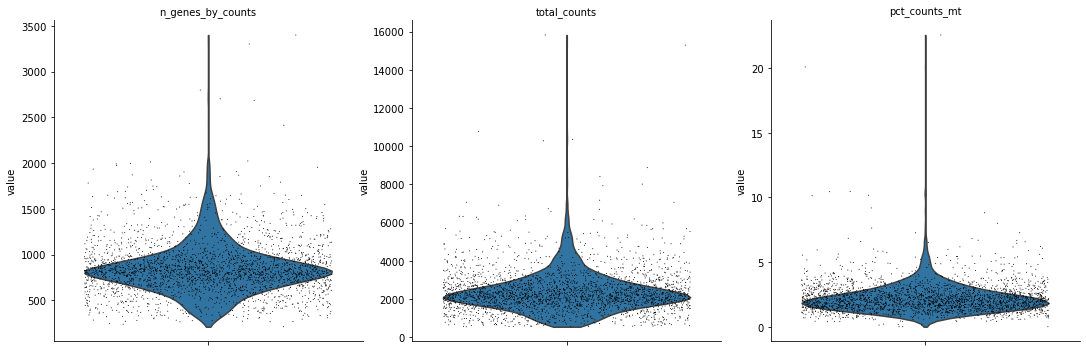

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

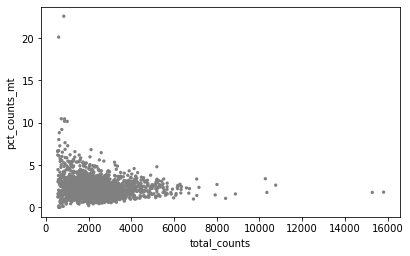

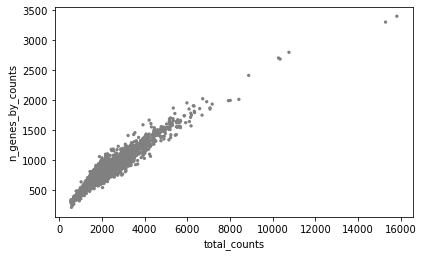

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)

/Users/dylankotliar/miniconda3/envs/sciviewer/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
sc.pp.log1p(adata)


In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


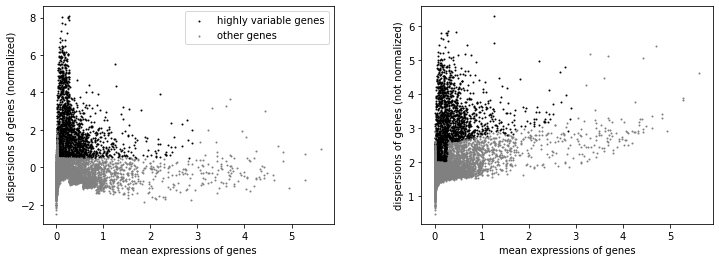

In [13]:
sc.pl.highly_variable_genes(adata)


In [14]:
adata.raw = adata

In [15]:
adata = adata[:, adata.var.highly_variable]

In [16]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [17]:
sc.pp.scale(adata, max_value=10)


In [18]:
sc.tl.pca(adata, svd_solver='arpack')

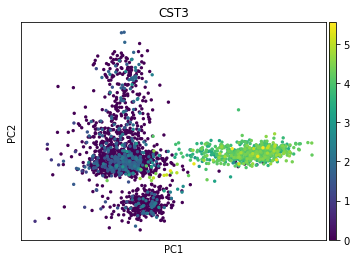

In [19]:
sc.pl.pca(adata, color='CST3')

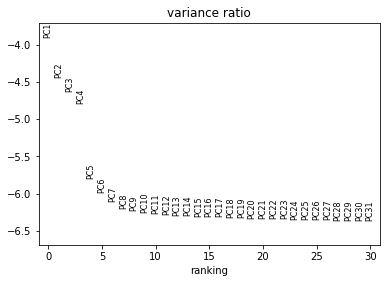

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)

In [21]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [23]:
sc.tl.umap(adata)

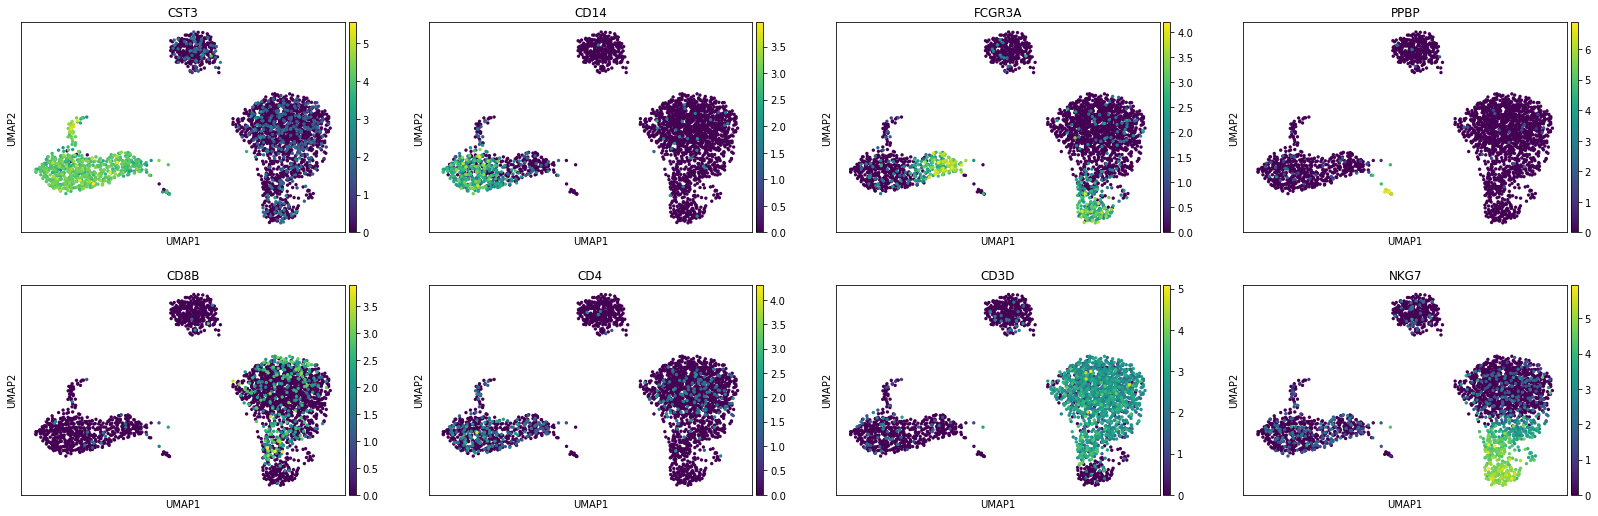

In [24]:
sc.pl.umap(adata, color=['CST3','CD14', 'FCGR3A', 'PPBP', 'CD8B', 'CD4', 'CD3D', 'NKG7'])

In [26]:
X = pd.DataFrame(adata.raw.X.todense(), index=adata.obs.index, columns=adata.raw.var.index)

In [27]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index, columns=['UMAP_1', 'UMAP_2'])
umap.head()

,UMAP_1,UMAP_2
AAACATACAACCAC-1,9.728817,4.212151
AAACATTGAGCTAC-1,3.799765,10.181845
AAACATTGATCAGC-1,7.023628,4.829623
AAACCGTGCTTCCG-1,-0.298523,2.024061
AAACCGTGTATGCG-1,8.018503,-0.300426


In [28]:
X.to_csv('../../data/pbmc3k_expression_log2TP10K_20210420.tsv', sep='\t')

In [29]:
umap.to_csv('../../data/pbmc3k_umap_20210420.tsv', sep='\t')

In [30]:
! mkdir -p ../../../sciviewer_data
! mkdir -p ../../../sciviewer_data/pbmc3k
! cp ../../data/*_20210420* ../../../sciviewer_data/pbmc3k

In [31]:
rm -R ../../data